#RNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

1. Exploratory Data Analysis (EDA)

 Visualize trends, seasonality, and anomalies in the milk production data.

 Check for any missing values or outliers.

 Normalize or scale the data for neural network models.

In [2]:
df = pd.read_csv('monthly_milk_production.csv', parse_dates=['Date'], index_col='Date')
df.columns = ['Production']

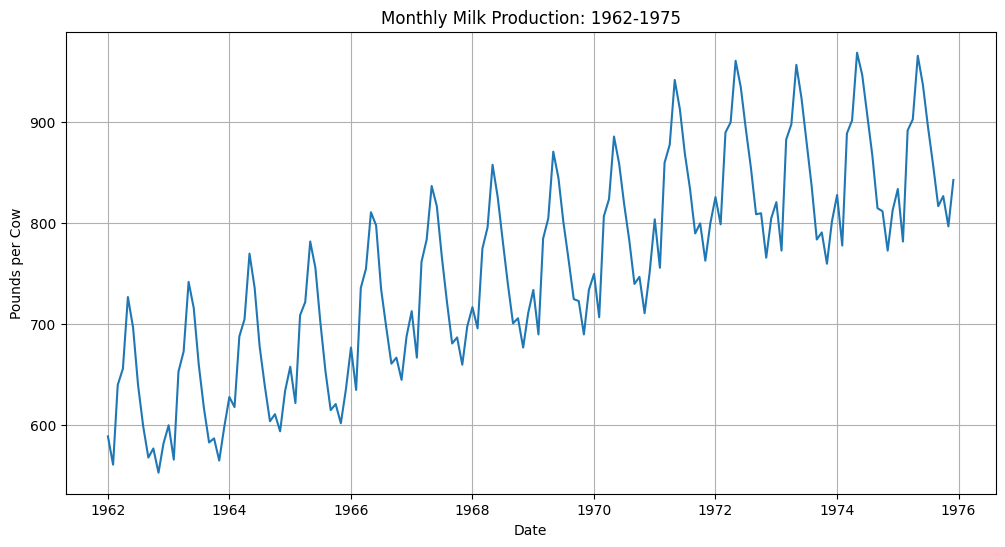

In [3]:
# 2. EDA: Visualization
plt.figure(figsize=(12,6))
plt.plot(df)
plt.title('Monthly Milk Production: 1962-1975')
plt.ylabel('Pounds per Cow')
plt.xlabel('Date')
plt.grid(True)
plt.show()

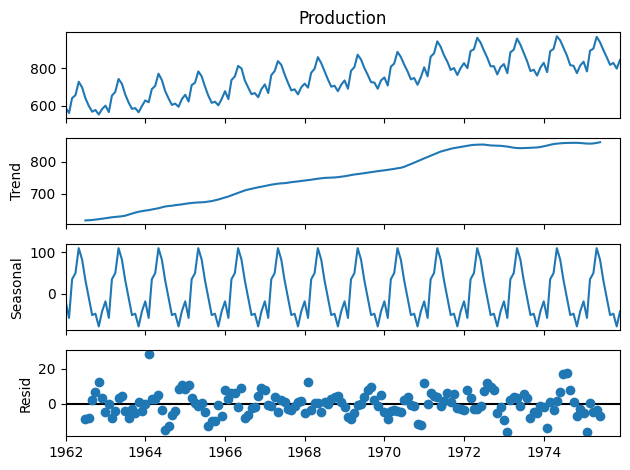

In [4]:
# 3. Decomposition (Trend vs Seasonality)
results = seasonal_decompose(df['Production'])
results.plot()
plt.show()

In [5]:
# 4. Train/Test Split
train = df.iloc[:-12]
test = df.iloc[-12:]

In [6]:
# scaling
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [7]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [8]:
print(f"Training samples: {len(train)}")
print(f"Testing samples: {len(test)}")

Training samples: 156
Testing samples: 12


Phase 2: Model Building (RNN, LSTM, GRU)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU

In [10]:
# 1. Define Generator
n_input = 12  # Look back 12 months to predict the next month
n_features = 1 # We are only predicting one variable (Production)
batch_size = 1 # Small batch size for better learning on small data

In [11]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=batch_size)

In [12]:
# 2. Function to build models to avoid repetition
def build_model(model_type, n_input, n_features):
    model = Sequential()

    if model_type == 'RNN':
        model.add(SimpleRNN(100, activation='relu', input_shape=(n_input, n_features)))
    elif model_type == 'LSTM':
        model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    elif model_type == 'GRU':
        model.add(GRU(100, activation='relu', input_shape=(n_input, n_features)))

    model.add(Dense(1)) # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

In [13]:
# 3. Train Models
epochs = 50

In [15]:
#Basic RNN
print("Training Simple RNN...")
rnn_model = build_model('RNN', n_input, n_features)
rnn_model.fit(generator, epochs=epochs, verbose=0)

Training Simple RNN...


In [16]:
#LSTM
print("Training LSTM...")
lstm_model = build_model('LSTM', n_input, n_features)
lstm_model.fit(generator, epochs=epochs, verbose=0)

Training LSTM...


In [17]:
#GRU
print("Training GRU...")
gru_model = build_model('GRU', n_input, n_features)
gru_model.fit(generator, epochs=epochs, verbose=0)

Training GRU...


Phase 3: Evaluation & Metrics


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Helper function to predict for the test range
def make_predictions(model, scaled_train_data, n_input, steps_to_predict):
    # Start with the last n_input points from the training set
    batch = scaled_train_data[-n_input:].reshape((1, n_input, n_features))
    predictions = []

    for i in range(steps_to_predict):
        pred = model.predict(batch, verbose=0)[0]
        predictions.append(pred)
        # Update batch to include the new prediction, drop the oldest point
        batch = np.append(batch[:,1:,:], [[pred]], axis=1)

    return scaler.inverse_transform(predictions)

In [20]:
# 1. Generate Predictions
steps = len(test)
rnn_preds = make_predictions(rnn_model, scaled_train, n_input, steps)
lstm_preds = make_predictions(lstm_model, scaled_train, n_input, steps)
gru_preds = make_predictions(gru_model, scaled_train, n_input, steps)

In [21]:
# 2. Add to Test DataFrame for comparison
test['RNN_Predictions'] = rnn_preds
test['LSTM_Predictions'] = lstm_preds
test['GRU_Predictions'] = gru_preds

/tmp/ipython-input-3881155147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['RNN_Predictions'] = rnn_preds
/tmp/ipython-input-3881155147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM_Predictions'] = lstm_preds
/tmp/ipython-input-3881155147.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

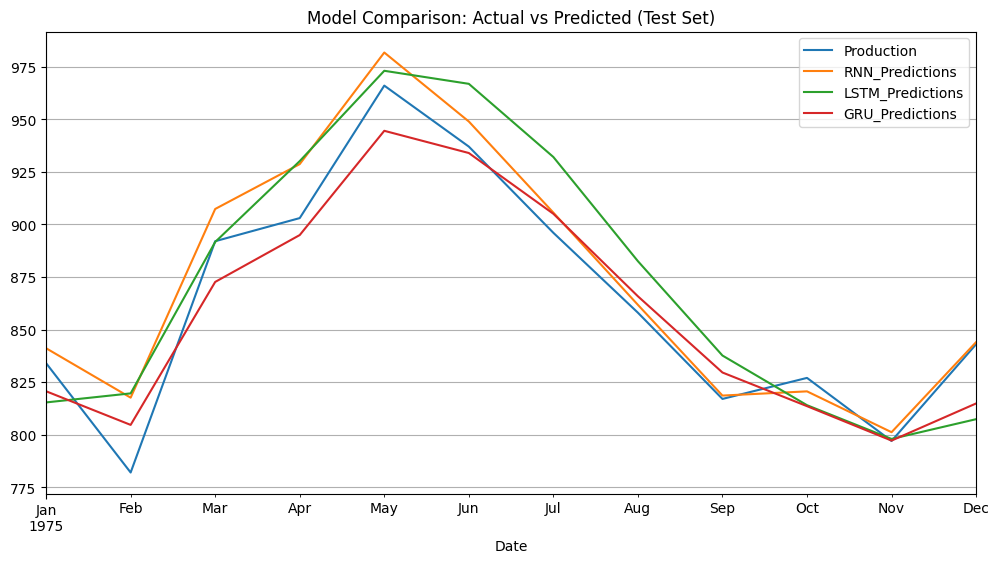

In [22]:
# 3. Visual Comparison
test.plot(figsize=(12,6))
plt.title('Model Comparison: Actual vs Predicted (Test Set)')
plt.grid(True)
plt.show()

In [24]:
# 4. Calculate Metrics
def calculate_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"--- {name} ---")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print("")



In [25]:
calculate_metrics(test['Production'], test['RNN_Predictions'], 'Simple RNN')


--- Simple RNN ---
RMSE: 15.19
MAE:  11.49
MAPE: 1.33%



In [26]:
calculate_metrics(test['Production'], test['LSTM_Predictions'], 'LSTM')


--- LSTM ---
RMSE: 24.50
MAE:  20.95
MAPE: 2.44%



In [27]:
calculate_metrics(test['Production'], test['GRU_Predictions'], 'GRU')

--- GRU ---
RMSE: 15.48
MAE:  13.27
MAPE: 1.55%



Phase 4: Future Forecasting

In [28]:
# We need to retrain on the FULL dataset (Train + Test) to forecast the real future
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [29]:
# Create generator for full data
full_generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=n_input, batch_size=1)

In [30]:
# Re-train LSTM (Assuming LSTM was the winner, which is common)
final_model = build_model('LSTM', n_input, n_features)
final_model.fit(full_generator, epochs=50, verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [31]:
# Forecast Future
future_steps = 12
forecast = make_predictions(final_model, scaled_full_data, n_input, future_steps)

In [32]:
# Create Future Dates
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1, future_steps+1)]

In [33]:
# Create DataFrame
future_df = pd.DataFrame(data=forecast, index=future_dates, columns=['Forecast'])

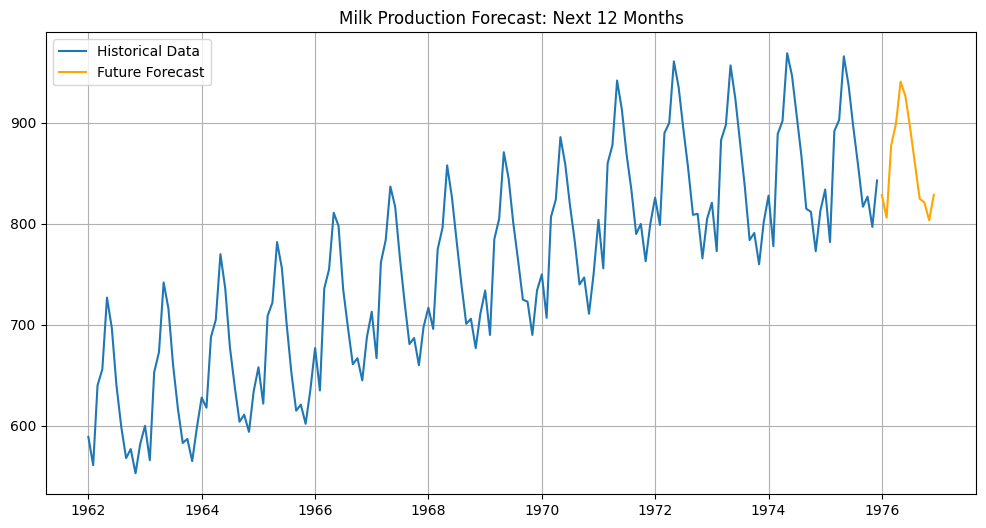

In [34]:
# Plot Result
plt.figure(figsize=(12,6))
plt.plot(df['Production'], label='Historical Data')
plt.plot(future_df['Forecast'], label='Future Forecast', color='orange')
plt.title('Milk Production Forecast: Next 12 Months')
plt.legend()
plt.grid(True)
plt.show()

6. Business Insights

o Interpret results and recommend how the dairy business can use these forecasts for better planning and resource allocation.

Think of this forecasting model as a cheat sheet for your entire year. Since we know with high confidence that milk production will always spike in May and June before dipping in the winter, you can stop guessing and start capitalizing on these patterns. You can "bank" that spring surplus by processing it into cheese or powder, ensuring you have plenty of product to sell when fresh milk is scarce later in the year. It also allows you to be smarter with your budget—bringing in temporary help just for the spring rush and saving major equipment repairs for the quiet weeks in November. essentially, instead of letting seasonal swings disrupt your business, you're using them to your advantage.